In [ ]:
saved_models_folder = "/mnt/cimec-storage6/users/nicola.debole/home/CQA/saved_models"
model_folder = "vlgcbm_celeba_2025_02_15_19_45"
concept_set = "/mnt/cimec-storage6/users/nicola.debole/home/CQA/data/concepts/celeba/handmade.txt"
labels_names = ["female", "male"]

# LOAD THE DATA

In [8]:
import sys
import os
os.chdir('/mnt/cimec-storage6/users/nicola.debole/home/CQA')
sys.path.append('/mnt/cimec-storage6/users/nicola.debole/home/CQA')
from datasets import GenericDataset
from torchvision import transforms
t = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224,224)),
        ])

model_name = model_folder.split("_")[0]
dataset = model_folder.split("_")[1]

data = GenericDataset(ds_name = dataset, split = 'test', transform = t)


2025-02-20 14:22:37.818 | DEBUG    | datasets:get_dataset:113 - Getting dataset shapes3d with kwargs {'split': 'test', 'transform': Compose(
    ToTensor()
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
)}
2025-02-20 14:22:38.304 | DEBUG    | datasets:__init__:33 - Loading dataset shapes3d from ./data/shapes3d/


# Run the model

In [9]:
import sys
import os
os.chdir('/mnt/cimec-storage6/users/nicola.debole/home/CQA')
sys.path.append('/mnt/cimec-storage6/users/nicola.debole/home/CQA')
from utils.args_utils import load_args
from models import get_model
from loguru import logger
from argparse import Namespace

args = {'load_dir':os.path.join(saved_models_folder,model_folder),
        
    }
args = Namespace(**args)
args = load_args(args)
# Load model
model = get_model(args)
logger.debug(f"Model loaded: {model}")

2025-02-20 14:22:39.712 | DEBUG    | utils.args_utils:load_args:13 - Loading from /mnt/cimec-storage6/users/nicola.debole/home/CQA/saved_models/llamaoracle_shapes3d_2025_02_03_18_42


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/cimec-storage6/users/nicola.debole/home/CQA/saved_models/llamaoracle_shapes3d_2025_02_03_18_42/args.txt'

In [4]:
outputs = model.run('test')

2025-02-20 14:18:42.074 | DEBUG    | models.base:run:58 - Running model on test split.
2025-02-20 14:18:42.075 | DEBUG    | models.base:get_loader:36 - Using default method get_loader for test
2025-02-20 14:18:46.632 | DEBUG    | datasets:get_dataset:113 - Getting dataset celeba with kwargs {'split': 'test', 'transform': Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fc8a97318a0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)}
Running test: 100%|██████████| 78/78 [01:47<00:00,  1.38s/it]


In [5]:
# Load last layer
try:
    print(model.model.final.weight)
    last_layer_weights = model.model.final.weight
except:
    last_layer_weights = model.model.final_layer.weight
    print(last_layer_weights)

Parameter containing:
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  4.6332e-02,  5.3017e-02,
          0.0000e+00, -1.2372e-01,  9.8621e-07, -1.3072e-01,  0.0000e+00,
          1.8611e-01,  2.1893e-02,  0.0000e+00,  0.0000e+00,  3.8210e-02,
          4.0574e-02, -2.3220e-01,  0.0000e+00,  1.4408e-01,  2.2409e-02,
          0.0000e+00,  1.2929e-01, -1.2383e-01, -1.8390e+00,  2.9477e-01,
          0.0000e+00,  1.1451e-02,  1.6922e-01,  2.8567e-01, -1.4181e-01,
          7.0111e-02,  2.8311e-01,  0.0000e+00,  2.1470e-01,  0.0000e+00,
          3.7573e-01,  1.4518e-01, -4.5122e-01, -2.0268e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -4.6331e-02, -5.3015e-02,
          0.0000e+00,  1.2372e-01, -9.8612e-07,  1.3072e-01,  0.0000e+00,
         -1.8611e-01, -2.1891e-02,  0.0000e+00,  0.0000e+00, -3.8210e-02,
         -4.0574e-02,  2.3220e-01,  0.0000e+00, -1.4408e-01, -2.2410e-02,
          0.0000e+00, -1.2929e-01,  1.2383e-01,  1.8390e+00, -2.9477e-01,
          0.0000e+00, -1.145

1579
Predicted male because of:
0.7369617819786072 No_Beard
0.5487258434295654 Oval_Face
0.5290094614028931 Wearing_Lipstick
-0.22403210401535034 Narrow_Eyes
-0.11419677734375 Wearing_Necktie
-0.11228296905755997 Black_Hair


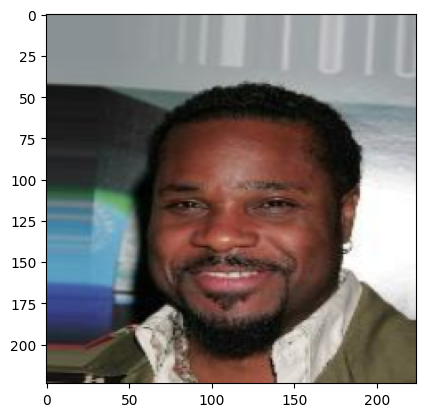

In [6]:
import torch
from matplotlib import pyplot as plt
with open(concept_set) as f:
        concept_names = f.read().split("\n")

def get_sample_decision_summary(idx):
    img,concepts,label = data[idx]
    prediction_label = outputs['labels_pred'][idx]
    pred = torch.argmax(prediction_label)
    print(f"Predicted {labels_names[pred]} because of:")
    concept_activations = outputs['concepts_pred'][idx].cpu()
    weights_label = last_layer_weights[pred].cpu()
    positive, pos_ids = torch.topk(weights_label*concept_activations, k=3, largest = True)
    negative, neg_ids = torch.topk(weights_label*concept_activations, k=3, largest = False)
    for i,p in enumerate(positive):
        index = pos_ids[i]
        print(f"{p.item()} {concept_names[index]}")
    for i,n in enumerate(negative):
        index = neg_ids[i]
        print(f"{n.item()} {concept_names[index]}")
    plt.imshow(img.permute(1,2,0))
    

import random

num = random.randint(0, 4999)  # Includes both 0 and 480
print(num)

num = 1836
get_sample_decision_summary(num)



